# <center> Trabajo Practico N2: Redes Recurrentes </center>
<div>
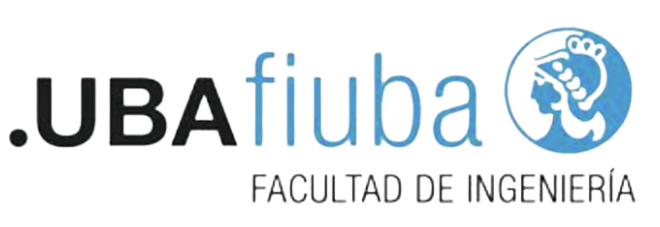
</div>

### <center>José Mornaghi y Lucas Argento</center>

## Introduccion

El proposito de este proyecto es entender el funcionamiento de las Redes Recurrentes.\
Variar entre RNNs y LSTM, modificar los parametros y aplicar las arquitecturas en dos diversos escenarios.

In [5]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time

In [6]:
torch.backends.mps.is_available()

True

### Creación RNN y LSTM


Tenemos que para una RNN

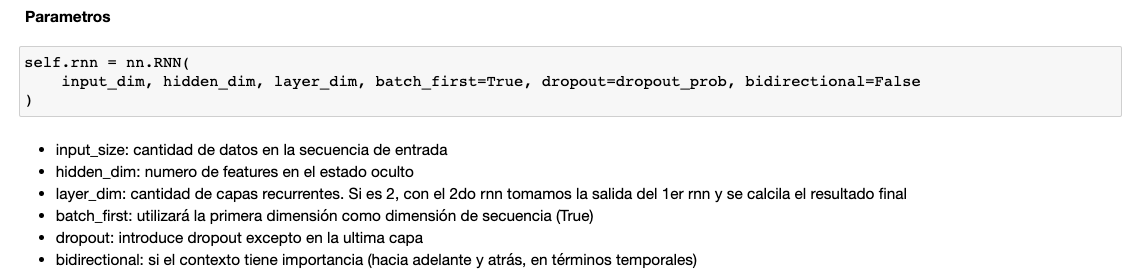

In [7]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob):
        super(RNN, self).__init__()

        # definición el numero de features del estado oculto y la cantidad de capas recurrentes de la red
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # definicion de las capas recurrentes de la red 
        self.rnn = nn.RNN(
            input_dim, hidden_dim, num_layers, batch_first = True, dropout = dropout_prob
        )
        
        # capa fully connected al final de la red 
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0):
        
        # inicializacion del estado oculto con zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # Propagación hacia adelante pasando la entrada y el estado oculto al modelo
        out, h0 = self.rnn(x, h0.detach()) # detach devuelve un nuevo tensor que no requiere gradiente

        # reshape de output para conectar al perceptron.
        out = out[:, -1, :]

        # convertir el estado final a la forma de salida deseada (batch_size, output_dim)
        out = self.fc(out)
        return out, h0

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
    
        # definición el numero de features del estado oculto y la cantidad de capas recurrentes de la red
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # capas LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # capa fully connected al final de la red. 
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):

        # inciializamos estado oculto en 0
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # ? algo de las lstm
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # pasamos la data al perceptrón
        out = self.fc(out[:, -1, :]) 
        return out

In [9]:
def crear_modelo(red, input_dim, hidden_dim, num_layers, output_dim, dropout_prob):
    red = red.upper()
    if red == "RNN":
        modelo = RNN(input_dim, hidden_dim, num_layers, output_dim, dropout_prob)
    elif red == "LSTM":
        modelo = LSTM(input_dim, hidden_dim, num_layers, output_dim)
    
    return modelo

In [46]:
def entrenar_modelo(red, model, x_train,  y_train, learning_rate, num_epochs, device):
    red = red.upper()
    model.to(device)

    # criterio de entrenamiento: Mean square error loss. 
    criterion = torch.nn.MSELoss(reduction='mean') # (state_action_values.float(), expected_state_action_values.float())
    
    # Adam optimizer <3 
    optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    # inicializo listas
    
    hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []
    # aca 5 = columnas del dataset
    h0 = torch.zeros(model.num_layers, 5, model.hidden_dim).requires_grad_()
    
    for t in range(num_epochs):
        # cambiamos data types porque nos tiraba error el criterion
        x_train = x_train.float()
        y_train = y_train.float()
        h0 = h0.float()
        
        # correr el modelo
        if red == "RNN":
            y_train_pred, h0 = model(x_train, h0)
            y_train_pred = y_train_pred.float()
        elif red == "LSTM":
            y_train_pred = model(x_train)
            y_train_pred = y_train_pred.float()

        # evaluar el modelo (y sombrero - y) --> y_sombrero = y_train_pred = output del modelo predecido. y_train = valores reales del set de train contra los que aprendemos. 
        loss = criterion(y_train_pred, y_train)
        print("Epoch ", t, "MSE: ", loss.item())
        
        # agrego en mi lista de historico el valor de la loss function
        hist[t] = loss.item()
        
        # reseteo gradientes
        optimiser.zero_grad()
        
        # backprop + actualizacion de parametros por ejemplo con SGD o Adam.
        loss.backward()
        optimiser.step()

    # informo training time y loss function
    training_time = time.time()-start_time
    print("\nTraining time: {}".format(training_time))

## BTC RNNs 

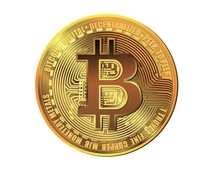

Fundamento teorico de una RNN:


Utilizando como base los scripts stock_prediction.ipynb, vamos a crear una RNN y LSTM que sea capaz de predecir el precio futuro del BTC en USD.

In [23]:
# Fuente: https://finance.yahoo.com/quote/BTC-USD/history?period1=1535760000&period2=1661990400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
df = pd.read_csv('Datasets/BTC-USD.csv')

Text(0.5, 1.0, 'BTC Price Time Series')

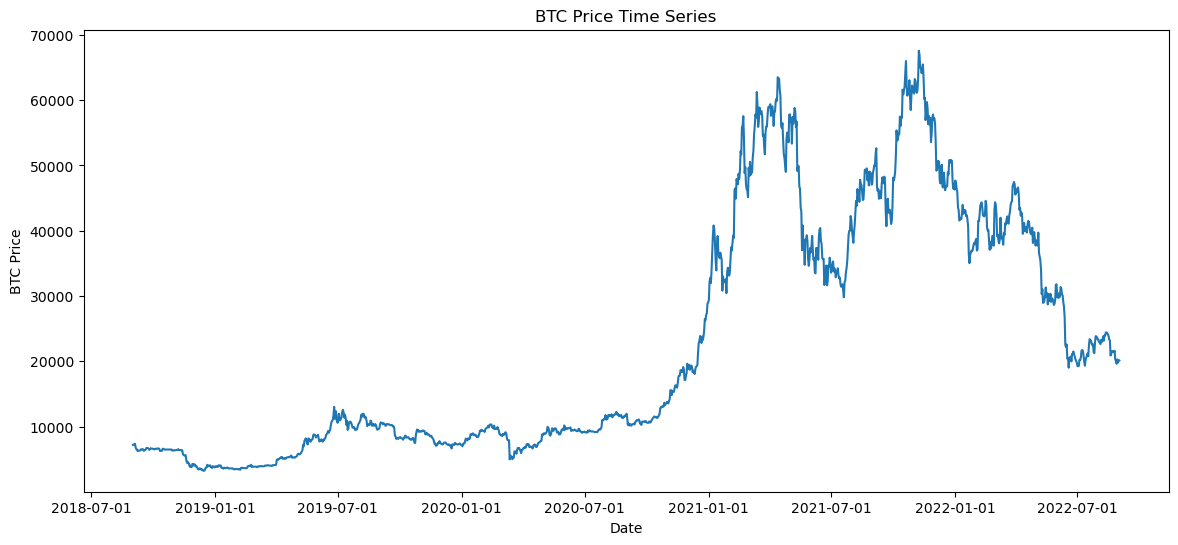

In [24]:
import matplotlib.dates as mdates
import datetime

fmt = mdates.DateFormatter('%Y-%m-%d')
x_date = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in df.Date]

fig, ax = plt.subplots(figsize=(14, 6))

plt.plot(x_date, df.Close)
plt.xticks(rotation=0)
ax.xaxis.set_major_formatter(fmt)

plt.xlabel('Date')
plt.ylabel('BTC Price');
plt.title("BTC Price Time Series")


### A) Hacer split del dataset en entrenamiento/test.

> Para no incurrer en Data Leakeage, se deberia splitear el dataset previo a realizar data wrangling (normalizacion/scaling). Explicación sobre el concepto de Data Leakage: https://machinelearningmastery.com/data-leakage-machine-learning/

**_Split en sets de entrenamiento, validación y testeo_**

In [30]:
def split_data(price, lookback):
    data_raw = price.to_numpy()
    data = []
    
    # se crean todas las posibles secuencias de la longitud de la secuencia
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    
    # 20% para set de testeo, el 80% para entrenamiento
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    # X son los valores anteriores (en un deltaT = lookback) e Y es el valor actual a predecir.
    
    # Train set
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    # Test set 
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test, data]

# Longitud de secuencia de los datos 
lookback = 5

# definimos la variable a predecir
price = df[['Close']]

# Splitted dataset
x_train, y_train, x_test, y_test, data = split_data(price, lookback)

# shape checking
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1166, 4, 1)
(291, 4, 1)
(1166, 1)
(291, 1)


**_Scaling_**

> Custom 3d scaler for X data and simple 2d scaler for y data

In [31]:
class MinMaxScaler3D(MinMaxScaler):

    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

In [32]:
myscaler = MinMaxScaler3D(feature_range=(-1, 1))

# scalling de ambos sets: train set
x_train = myscaler.fit_transform(x_train)

# test set
x_test = myscaler.fit_transform(x_test)

#print("Dimensions post scaling: ", "\nx_train: ",x_train.shape,"\ny_train: ",y_train.shape,"\nx_test: ",x_test.shape,"\ny_test: ",y_test.shape)

In [33]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# escalamos para train y test por separado hay que cambiar a logica numpy
y_train = scaler.fit_transform(y_train.reshape(-1,1))

# escalamos para test set
y_test = scaler.fit_transform(y_test.reshape(-1,1))

In [34]:
# shape checking
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1166, 4, 1)
(291, 4, 1)
(1166, 1)
(291, 1)


In [35]:
x_train

array([[[-0.87699412],
        [-0.87452342],
        [-0.87491702],
        [-0.8717583 ]],

       [[-0.87452342],
        [-0.87491702],
        [-0.8717583 ],
        [-0.88944304]],

       [[-0.87491702],
        [-0.8717583 ],
        [-0.88944304],
        [-0.89764014]],

       ...,

       [[ 0.86818481],
        [ 1.        ],
        [ 0.98150165],
        [ 0.9200499 ]],

       [[ 1.        ],
        [ 0.98150165],
        [ 0.9200499 ],
        [ 0.91864248]],

       [[ 0.98150165],
        [ 0.9200499 ],
        [ 0.91864248],
        [ 0.89395669]]])

In [36]:
# convertimos a tensores de torch

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

In [37]:
x_train.size()

torch.Size([1166, 4, 1])

### B) Modificar con diferentes valores la dimensión del vector de la secuencia de entrada, la cantidad de capas, número de features en el estado oculto. Explicar que sucede y en que caso es conveniente un valor mayor o menor

In [38]:
RNN_0 = crear_modelo("RNN", input_dim = 1, hidden_dim = 64 , num_layers = 2, output_dim = 1, dropout_prob = 0)

In [47]:
device = "cpu"

#x_train.to(device)
#y_train.to(device)

entrenar_modelo("RNN", RNN_0, x_train,  y_train, learning_rate = 0.001, num_epochs = 100, device = device) # corre ful rapido

Epoch  0 MSE:  0.6362932920455933
Epoch  1 MSE:  0.5075595378875732
Epoch  2 MSE:  0.40302756428718567
Epoch  3 MSE:  0.31789660453796387
Epoch  4 MSE:  0.2506183683872223
Epoch  5 MSE:  0.20202337205410004
Epoch  6 MSE:  0.17387868463993073
Epoch  7 MSE:  0.1654905527830124
Epoch  8 MSE:  0.16900776326656342
Epoch  9 MSE:  0.1713465005159378
Epoch  10 MSE:  0.16325266659259796
Epoch  11 MSE:  0.14358572661876678
Epoch  12 MSE:  0.11673127859830856
Epoch  13 MSE:  0.08858761936426163
Epoch  14 MSE:  0.0639454573392868
Epoch  15 MSE:  0.04538976773619652
Epoch  16 MSE:  0.03326236084103584
Epoch  17 MSE:  0.026248978450894356
Epoch  18 MSE:  0.02222214639186859
Epoch  19 MSE:  0.01910550147294998
Epoch  20 MSE:  0.015652408823370934
Epoch  21 MSE:  0.011962526477873325
Epoch  22 MSE:  0.009416081011295319
Epoch  23 MSE:  0.009797614067792892
Epoch  24 MSE:  0.013753940351307392
Epoch  25 MSE:  0.019541921094059944
Epoch  26 MSE:  0.023727355524897575
Epoch  27 MSE:  0.023796046152710915

### C) Dibujar la curva de la función costo en funcion de los pasos de entrenamiento

### D) Comparar el entrenamiento de una RNN y LSTM

### E) ¿Qué metricas utilizaría para hacer una comparación objetiva entre la performance de cada modelo (RNN vs LSTM)?

## Ejercicio 2: Predicción de dominio a partir de un título de un ítem de un e-commerce

A partir de un dataset de productos de MercadoLibre, buscaremos utilizar RNNs para clasificar los textos. 

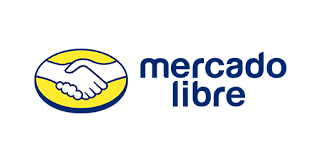


### A) Hacer split del dataset en entrenamiento/test/valid.

### B)  Elegir 2 clases y desarrollar un modelo de clasificación binaria.

### C) Dibujar la curva de la función costo en función de los pasos de entrenamiento.

### D) Pruebe cambiar al menos dos parámetros de la red. Explique.

### E) ¿Qué métricas utilizaría para medir objetivamente la performance del modelo?

### F) Repita estos pasos pero esta vez seleccionando 4 clases del dataset dado.